## 7. epoch调参分析

In [1]:
import sys
sys.path = ["../../.."]+ sys.path # 切换到项目目录下

import scanpy as sc
import scvelo as scv
import velovgi

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


Global seed set to 0
/usr/local/conda/envs/velovgi/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/usr/local/conda/envs/velovgi/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
from torch_geometric import seed_everything

seed = 0
seed_everything(seed)

1. 读取数据

In [3]:
# 红系成熟部分
adata_filename = "./data/gastrulation.h5ad"

adata = scv.read(adata_filename)
batch_key = "stage"
cluster_key = "celltype"
adata

AnnData object with n_obs × n_vars = 500 × 53801
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

## 预处理

In [4]:
batch_pair_list = None
batch_pair_list = [
    ["E7.0", "E7.25"],
    ["E7.25", "E7.5"],
    ["E7.5", "E7.75"],
    ["E7.75", "E8.0"],
    ["E8.0", "E8.25"],
    ["E8.25", "E8.5"],
]
knn_mask, bnn_mask, subsample_adata = velovgi.pp.preprocess(adata, sample_mode="random", batch_key=batch_key, batch_pair_list=batch_pair_list)

Filtered out 51277 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
calculating knn and bnn mask...
pair_list : [['E7.0', 'E7.25'], ['E7.25', 'E7.5'], ['E7.5', 'E7.75'], ['E7.75', 'E8.0'], ['E8.0', 'E8.25'], ['E8.25', 'E8.5']]
smoothing...
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## 断点训练

In [5]:
model_epoch_sep_savedir = "./model/epoch_parameter_adjustment" # TODO: 这里保存路径以后需要更改
log_epoch_sep_save_dir = "./log/epoch_parameter_adjustment"

max_epochs = 200
epoch_list = range(0, max_epochs+1, 50)[1:] # TOOD: 数据量越大，查看的epoch间隔应该越小


# 每次断点指定模型训练的epoch
sep_epoch_list = [epoch_list[0]] 
for i in range(1, len(epoch_list)):
    sep_epoch_list.append(epoch_list[i]-epoch_list[i-1])
# sep_epoch_list.append(max_epochs-epoch_list[-1]) # 最后这个不保存
sep_epoch_list

[50, 50, 50, 50]

In [7]:
from pytorch_lightning import loggers

velovgi.tl.VELOVGI.setup_anndata(adata=subsample_adata, spliced_layer="Ms", unspliced_layer="Mu")
velovgi_model = velovgi.tl.VELOVGI(subsample_adata)

for i in range(len(epoch_list)):
    epoch = epoch_list[i]
    sep_epoch = sep_epoch_list[i] # 此次断点训练的epoch数目
    print(epoch, sep_epoch)
    name = "%d_epoch(max_epochs=%d)"%(epoch, max_epochs) # 模型的训练名称
    logger = loggers.TensorBoardLogger(save_dir=log_epoch_sep_save_dir, name=name) # 构造日志文件
    
    velovgi_model.train(max_epochs=sep_epoch, logger=logger, checkpoint_mode="checkpoint")
    velovgi_model.save("%s/%s"%(model_epoch_sep_savedir, name))# 模型保存

50 50
初始训练，初始化runner参数
choosing neighbor minibatch


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [00:07<00:00,  6.90it/s, loss=5.51e+05, v_num=2]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:07<00:00,  6.60it/s, loss=5.51e+05, v_num=2]
100 50
断点继续训练
断点的epochs： 50


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=4.78e+05, v_num=1]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:07<00:00,  6.76it/s, loss=4.78e+05, v_num=1]
150 50
断点继续训练
断点的epochs： 50


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [00:07<00:00,  5.52it/s, loss=4.26e+05, v_num=1]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:07<00:00,  6.27it/s, loss=4.26e+05, v_num=1]
200 50
断点继续训练
断点的epochs： 50


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [00:07<00:00,  6.93it/s, loss=3.88e+05, v_num=1]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:07<00:00,  6.46it/s, loss=3.88e+05, v_num=1]


## 读取断点训练结果，看看整体和基因速率图

1. 读取断点训练结果

In [8]:
name_list =[]
adata_list = []

for i in range(len(epoch_list)):
    epoch = epoch_list[i]
    name = "%d_epoch(max_epochs=%d)"%(epoch, max_epochs) # 模型的训练名称
    name_list.append(name)
    # 提取模型
    model = velovgi.tl.VELOVGI.load("%s/%s"%(model_epoch_sep_savedir, name), adata=subsample_adata, use_gpu=True)
     # 输出结果
    velovgi.tl.add_velovi_outputs_to_adata(subsample_adata, model)
    tmp_adata = adata.copy()
    velovgi.pp.moment_recover(tmp_adata, subsample_adata)
    adata_list.append(tmp_adata)
adata_list

INFO     File ./model/epoch_parameter_adjustment/50_epoch(max_epochs=200)/model.pt already downloaded              
INFO     File ./model/epoch_parameter_adjustment/100_epoch(max_epochs=200)/model.pt already downloaded             
INFO     File ./model/epoch_parameter_adjustment/150_epoch(max_epochs=200)/model.pt already downloaded             
INFO     File ./model/epoch_parameter_adjustment/200_epoch(max_epochs=200)/model.pt already downloaded             


[AnnData object with n_obs × n_vars = 500 × 2000
     obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
     uns: 'celltype_colors', 'neighbors', 'sample_recover'
     obsm: 'X_pca', 'X_umap'
     layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'velocity_u', 'fit_t'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 500 × 2000
     obs: 'barcode', 'sample', 'stage', 'sequencing.batch

2. 绘制整体速率图

50_epoch(max_epochs=200)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/12 cores)


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 2 regions of root cells and 2 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
100_epoch(max_epochs=200)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/12 cores)


/usr/local/conda/envs/velovgi/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 2 regions of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
150_epoch(max_epochs=200)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/12 cores)


/usr/local/conda/envs/velovgi/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 2 regions of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
200_epoch(max_epochs=200)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/12 cores)


/usr/local/conda/envs/velovgi/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/usr/local/conda/envs/velovgi/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


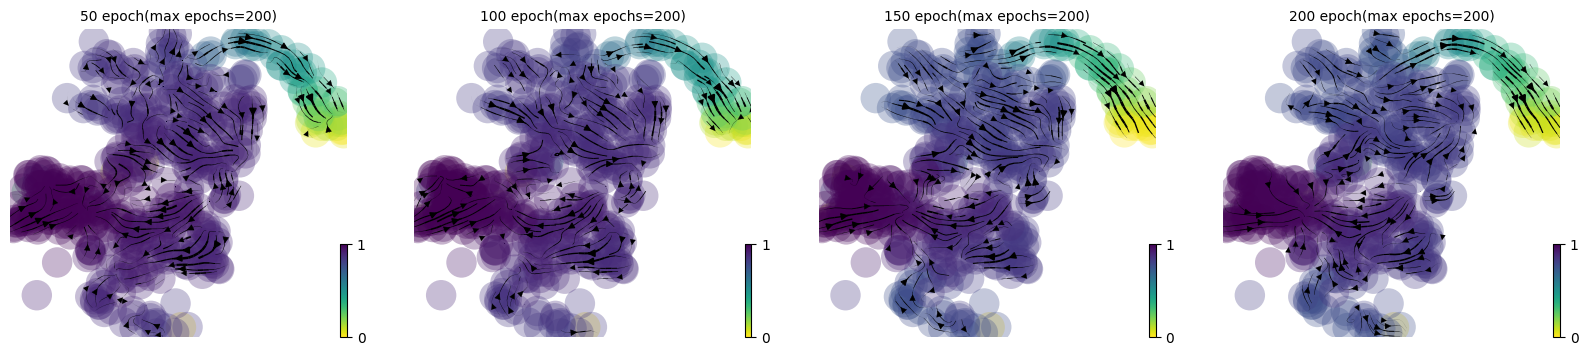

In [9]:
n = len(epoch_list)
fig, ax = velovgi.pl.calc_fig(n)
for i in range(n):
    print(name_list[i])
    name = name_list[i]
    tmp_adata = adata_list[i]
    scv.tl.velocity_graph(tmp_adata) # 转移矩阵计算
    scv.tl.velocity_pseudotime(tmp_adata) # 速率的伪时间计算
    scv.pl.velocity_embedding_stream(tmp_adata, color="velocity_pseudotime", ax=ax[i], title=name, show=False)

## 调参选择

目前这里看来，应该是到450左右最好。但实际最好还是看tensorborad的loss面板，发现实际对应的原本的200左右的epoch。